In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings('ignore')
from gymnasium.envs.classic_control.cartpole import CartPoleEnv
class CartPoleWithFriction(CartPoleEnv):
    def __init__(self, friction_coef=0.1, render_mode=None):  # 加入 render_mode 參數
        self.friction_coef = friction_coef
        super().__init__(render_mode=render_mode)  # 傳遞給父類別
    def step(self, action):
        # 與原本相同的力（左右推）
        force = self.force_mag if action == 1 else -self.force_mag
        x, x_dot, theta, theta_dot = self.state

        # 添加地面摩擦力：對 cart 的速度做衰減
        friction_force = -self.friction_coef * x_dot
        force += friction_force

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
                   (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        # 狀態更新
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = (x, x_dot, theta, theta_dot)

        terminated = x < -self.x_threshold \
                     or x > self.x_threshold \
                     or theta < -self.theta_threshold_radians \
                     or theta > self.theta_threshold_radians
        terminated = bool(terminated)

        reward = 1.0
        self.steps_beyond_terminated = None if not terminated else self.steps_beyond_terminated

        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

def make_env_with_friction(friction_coef):
    def _init():
        return CartPoleWithFriction(friction_coef=friction_coef)
    return _init

In [2]:
friction_values = [0.0, 0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1.0]
friction_values = np.linspace(0,10,11)
friction_values

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [3]:


# def f(mu_1, mu_2, m):


#     return #

for mu in friction_values:
    print(f"Training with friction = {mu}")
    env = DummyVecEnv([make_env_with_friction(mu)])
    model = PPO("MlpPolicy", env, verbose=0, device="cpu")
    # Training parameters
    total_episodes = 10
    timesteps_per_episode = 5000
    episode_rewards = []
    # Training loop
    for episode in range(total_episodes):
        model.learn(total_timesteps=timesteps_per_episode, reset_num_timesteps=False)


    test_env = CartPoleWithFriction(friction_coef=mu, render_mode="rgb_array")
    Total_TIME =  5000
    obs, info = test_env.reset()
    test_env._max_episode_steps = Total_TIME  # 設定更高的限制
    frames = []
    done = False
    step_count = 0
    total_reward = 0
    
    # Data recording arrays
    cart_positions = []
    cart_velocities = []
    pole_angles = []
    pole_angular_velocities = []
    actions_taken = []
    rewards_received = []
    timestamps = []
    pole_tip_offsets = []  # 在前面定義
    
    
    # Collect frames and data for analysis
    while not done and step_count < 5000:
        # Record current state before action
        cart_position = obs[0]      # Cart position
        cart_velocity = obs[1]      # Cart velocity  
        pole_angle = obs[2]         # Pole angle (radians)
        pole_angular_velocity = obs[3]  # Pole angular velocity
        
        # Store state data
        cart_positions.append(cart_position)
        cart_velocities.append(cart_velocity)
        pole_angles.append(pole_angle)
        pole_angular_velocities.append(pole_angular_velocity)
        timestamps.append(step_count * 0.02)  # Assuming 50Hz (0.02s per step)
        # 在 while 迴圈內的每一步加這行：
        pole_tip_offset = test_env.unwrapped.length * np.sin(pole_angle)
        pole_tip_offsets.append(pole_tip_offset)
        
        # Get action from trained model
        action, _ = model.predict(obs, deterministic=True)
        actions_taken.append(action)
        
        # Take action and observe result
        obs, reward, terminated, truncated, info = test_env.step(action)
        rewards_received.append(reward)
        total_reward += reward
        done = terminated or truncated
        
        # Render and store frame
        frame = test_env.render()
        frames.append(frame)
        step_count += 1
    
    test_env.close()
    
    print(f"Final test: Lasted {step_count} steps, Total reward: {total_reward}")
    
    # Convert lists to numpy arrays
    cart_positions = np.array(cart_positions)
    cart_velocities = np.array(cart_velocities)
    pole_angles = np.array(pole_angles)
    pole_angular_velocities = np.array(pole_angular_velocities)
    actions_taken = np.array(actions_taken)
    rewards_received = np.array(rewards_received)
    timestamps = np.array(timestamps)
    pole_tip_offsets = np.array(pole_tip_offsets)
    
    recorded_data = {
        'cart_positions': cart_positions,
        'cart_velocities': cart_velocities,
        'pole_angles': pole_angles,
        'pole_angular_velocities': pole_angular_velocities,
        'actions_taken': actions_taken,
        'rewards_received': rewards_received,
        'timestamps': timestamps,
        'total_steps': step_count,
        'total_reward': total_reward,
        'pole_tip_offsets': pole_tip_offsets,
        'episode_rewards': np.array(episode_rewards)
    }
    # Save data to numpy file
    data_filename = f"cartpole_training_data_{mu:.1f}.npz"
    np.savez(data_filename, **recorded_data)
    print(f"✅ All training and test data saved to '{data_filename}'")
            

Training with friction = 0.0
Final test: Lasted 5000 steps, Total reward: 5000.0
✅ All training and test data saved to 'cartpole_training_data_0.0.npz'
Training with friction = 1.0
Final test: Lasted 5000 steps, Total reward: 5000.0
✅ All training and test data saved to 'cartpole_training_data_1.0.npz'
Training with friction = 2.0
Final test: Lasted 5000 steps, Total reward: 5000.0
✅ All training and test data saved to 'cartpole_training_data_2.0.npz'
Training with friction = 3.0
Final test: Lasted 5000 steps, Total reward: 5000.0
✅ All training and test data saved to 'cartpole_training_data_3.0.npz'
Training with friction = 4.0
Final test: Lasted 5000 steps, Total reward: 5000.0
✅ All training and test data saved to 'cartpole_training_data_4.0.npz'
Training with friction = 5.0
Final test: Lasted 5000 steps, Total reward: 5000.0
✅ All training and test data saved to 'cartpole_training_data_5.0.npz'
Training with friction = 6.0
Final test: Lasted 5000 steps, Total reward: 5000.0
✅ All t

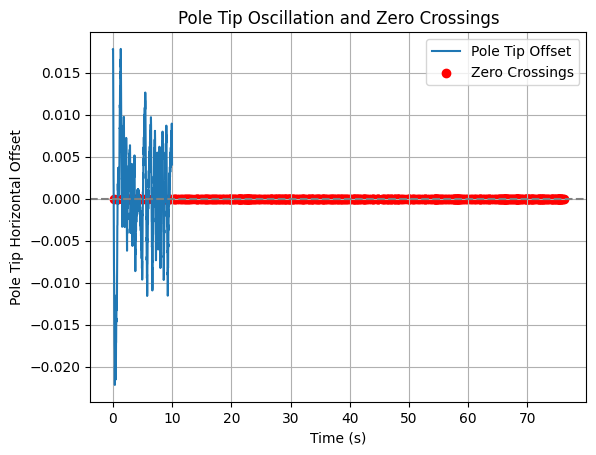

In [20]:

data = np.load("cartpole_training_data_3.0.npz")

cart_pos = data["cart_positions"]
cart_vel = data["cart_velocities"]
pole_ang = data["pole_angles"]
pole_ang_vel = data["pole_angular_velocities"]
pole_tip_offsets = data["pole_tip_offsets"]

zero_crossing_indices = np.where(np.diff(np.sign(pole_tip_offsets)) != 0)[0]

# 加上 1，因為 np.diff 產生的是 N-1 長度
zero_crossing_times = timestamps[zero_crossing_indices + 1]
plt.plot(timestamps[:500], pole_tip_offsets[:500], label='Pole Tip Offset')
plt.scatter(zero_crossing_times[:500], np.zeros_like(zero_crossing_times)[:500], color='red', label='Zero Crossings')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Pole Tip Horizontal Offset")
plt.legend()
plt.title("Pole Tip Oscillation and Zero Crossings")
plt.grid(True)
plt.show()

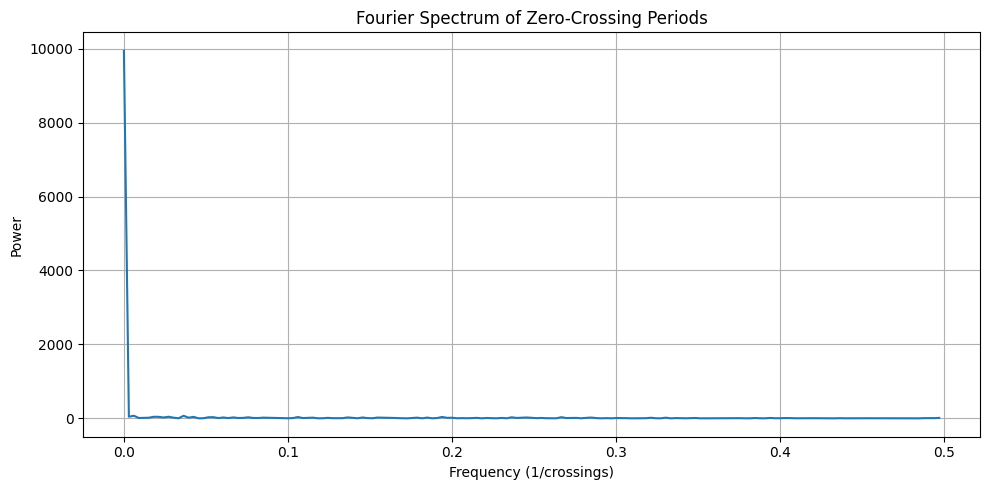

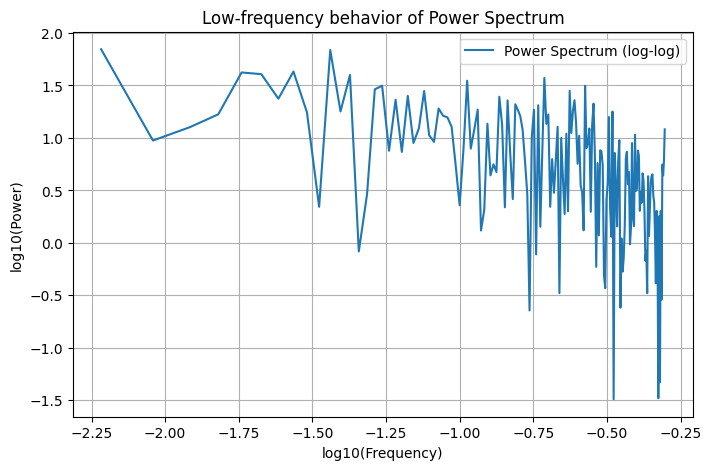

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# 假設你已有 zero_crossing_times，如：
# zero_crossing_times = np.array([...])

# Step 1: 取偶數 index 的過零時間點
even_crossing_times = zero_crossing_times[::2]
# Step 2: 計算每個週期的時間長度
periods = np.diff(even_crossing_times)  # 相鄰時間差，應該接近週期
N = len(periods)
dt = 1  # 每個樣本對應一個週期，不需要真實時間尺度

# Step 3: FFT 分析
yf = fft(periods)  # 去除 DC 分量 (均值)
xf = fftfreq(N, dt)

# 只取正頻率部分
xf_pos = xf[:N//2]
power_spectrum = np.abs(yf[:N//2])**2

# Step 4: 繪圖
plt.figure(figsize=(10, 5))
plt.plot(xf_pos, power_spectrum)
plt.xlabel("Frequency (1/crossings)")
plt.ylabel("Power")
plt.title("Fourier Spectrum of Zero-Crossing Periods")
plt.grid(True)
plt.tight_layout()
plt.show()


# 假設 you have `periods` = np.diff(even_crossing_times)
periods = periods - np.mean(periods)  # 去掉均值
N = len(periods)
dt = 1  # index 間隔

yf = fft(periods)
xf = fftfreq(N, dt)
xf = xf[:N//2]
power = np.abs(yf[:N//2])**2
Q = N
# 避免 log(0)，加個 epsilon
epsilon = 1e-12
log_xf = np.log10(xf[2:Q] + epsilon)
log_power = np.log10(power[2:Q] + epsilon)

plt.figure(figsize=(8, 5))
plt.plot(log_xf, log_power, label='Power Spectrum (log-log)')
plt.xlabel('log10(Frequency)')
plt.ylabel('log10(Power)')
plt.title('Low-frequency behavior of Power Spectrum')
plt.grid(True)
plt.legend()
plt.show()

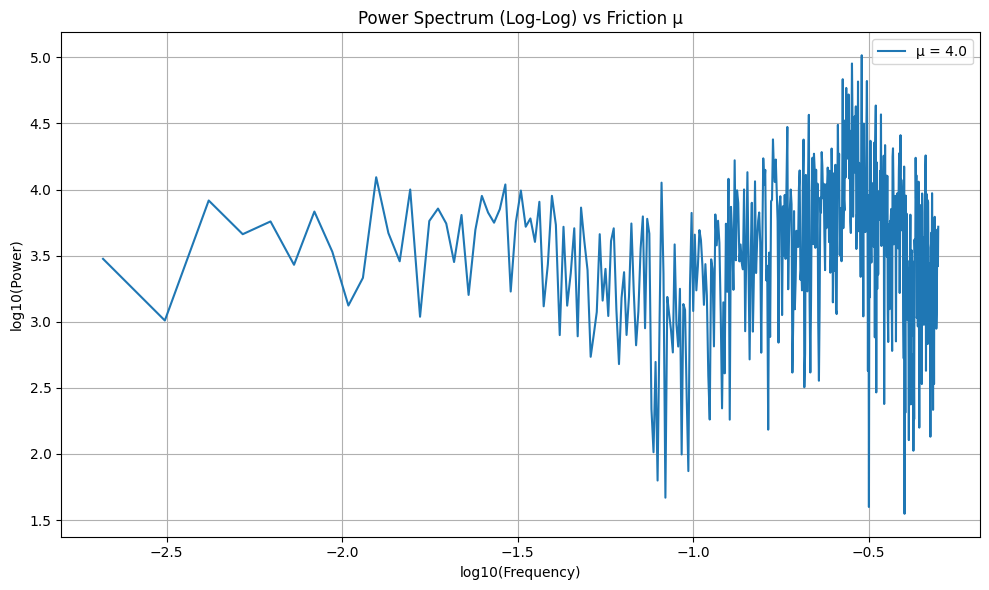

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq



plt.figure(figsize=(10, 6))  # 圖表放外面，全部畫在一起
epsilon = 1e-12  # 避免 log(0)

for mu in friction_values[4:5]:
    data = np.load(f"cartpole_training_data_{mu:.1f}.npz")

    pole_tip_offsets = data["pole_tip_offsets"]
    zero_crossing_indices = np.where(np.diff(np.sign(pole_tip_offsets)) != 0)[0]
    zero_crossing_times = zero_crossing_indices
    even_crossing_times = zero_crossing_times[::2]

    periods = np.diff(even_crossing_times)
    if len(periods) < 4:
        print(f"μ={mu:.1f}: 週期不足，略過")
        continue

    #periods = periods - np.mean(periods)
    N = len(periods)
    dt = 1

    yf = fft(periods)
    xf = fftfreq(N, dt)
    xf = xf[:N//2]
    power = np.abs(yf[:N//2])**2

    log_xf = np.log10(xf[2:Q] + epsilon)
    log_power = np.log10(power[2:Q] + epsilon)
    plt.plot(log_xf, log_power, label=f'μ = {mu:.1f}')

plt.xlabel('log10(Frequency)')
plt.ylabel('log10(Power)')
plt.title('Power Spectrum (Log-Log) vs Friction μ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


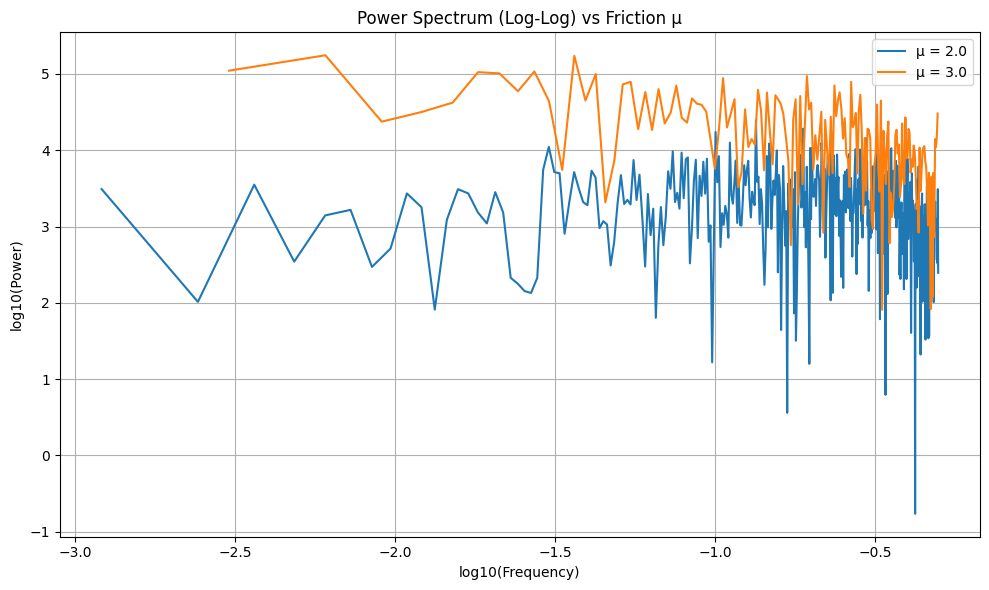

In [12]:


plt.figure(figsize=(10, 6))  # 圖表放外面，全部畫在一起
epsilon = 1e-12  # 避免 log(0)

for mu in friction_values[2:4]:
    data = np.load(f"cartpole_training_data_{mu:.1f}.npz")

    pole_tip_offsets = data["pole_tip_offsets"]
    zero_crossing_indices = np.where(np.diff(np.sign(pole_tip_offsets)) != 0)[0]
    zero_crossing_times = zero_crossing_indices
    even_crossing_times = zero_crossing_times[::2]

    periods = np.diff(even_crossing_times)
    if len(periods) < 4:
        print(f"μ={mu:.1f}: 週期不足，略過")
        continue

    #periods = periods - np.mean(periods)
    N = len(periods)
    dt = 1

    yf = fft(periods)
    xf = fftfreq(N, dt)
    xf = xf[:N//2]
    power = np.abs(yf[:N//2])**2

    log_xf = np.log10(xf[1:Q] + epsilon)
    log_power = np.log10(power[1:Q] + epsilon)
    plt.plot(log_xf, log_power, label=f'μ = {mu:.1f}')

plt.xlabel('log10(Frequency)')
plt.ylabel('log10(Power)')
plt.title('Power Spectrum (Log-Log) vs Friction μ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
len(power[1:Q])

In [ ]:


mu= [....]
length=[....]
mu_2=[...]

for m...:
    f(a,,,)